# MLHAT - Tutorial of execution

This notework shows an example steps sequences to declare, use and evaluate a MLHAT model in the proposed framework.

## Multi-label data streams

The datasets used in this experimentation are publicly available in the [Multi-Label Classification Dataset Repository](https://www.uco.es/kdis/mllresources/). To be used in this framework they have been wrapped in the wrapper for the River data streams under the `ml_datasets` package. More information about reading data in River can be found [here](https://riverml.xyz/0.17.0/recipes/reading-data/). Next, the *CHD* dataset is loaded below as an example.

In [1]:
from ml_datasets import *

stream = Emotions()
stream

Also called Music. Is a small dataset to classify music into emotions that it evokes according to the Tellegen-Watson-Clark model of mood: amazed-suprised, happy-pleased, relaxing-calm, quiet-still, sad-lonely and angry-aggresive. It consists of 593 songs with 6 classes.

G. Tsoumakas, I. Katakis, and I. Vlahavas. Effective and Efficient Multilabel Classification in Domains with Large Number of Labels. In Proc. ECML/PKDD 2008 Workshop on Mining Multidimensional Data (MMD'08), 2008.

      Name  Emotions                                                                              
      Task  Multi-output binary classification                                                    
   Samples  593                                                                                   
  Features  72                                                                                    
   Outputs  6                                                                                     
    Sparse  False

We can also take a look to the first sample, which is composed of two Python dictionaries: one for the input features and one with the label set that would be activated in the output space from the input:

In [2]:
x, y = next(iter(stream))
print("Input:", x)
print("Output:", y)

Input: {'Mean_Acc1298_Mean_Mem40_Centroid': 0.034741, 'Mean_Acc1298_Mean_Mem40_Rolloff': 0.089665, 'Mean_Acc1298_Mean_Mem40_Flux': 0.091225, 'Mean_Acc1298_Mean_Mem40_MFCC_0': -73.302422, 'Mean_Acc1298_Mean_Mem40_MFCC_1': 6.215179, 'Mean_Acc1298_Mean_Mem40_MFCC_2': 0.615074, 'Mean_Acc1298_Mean_Mem40_MFCC_3': 2.03716, 'Mean_Acc1298_Mean_Mem40_MFCC_4': 0.804065, 'Mean_Acc1298_Mean_Mem40_MFCC_5': 1.301409, 'Mean_Acc1298_Mean_Mem40_MFCC_6': 0.558576, 'Mean_Acc1298_Mean_Mem40_MFCC_7': 0.672063, 'Mean_Acc1298_Mean_Mem40_MFCC_8': 0.783788, 'Mean_Acc1298_Mean_Mem40_MFCC_9': 0.76664, 'Mean_Acc1298_Mean_Mem40_MFCC_10': 0.458712, 'Mean_Acc1298_Mean_Mem40_MFCC_11': 0.530384, 'Mean_Acc1298_Mean_Mem40_MFCC_12': 0.812429, 'Mean_Acc1298_Std_Mem40_Centroid': 0.028851, 'Mean_Acc1298_Std_Mem40_Rolloff': 0.129039, 'Mean_Acc1298_Std_Mem40_Flux': 0.039614, 'Mean_Acc1298_Std_Mem40_MFCC_0': 5.762173, 'Mean_Acc1298_Std_Mem40_MFCC_1': 1.636819, 'Mean_Acc1298_Std_Mem40_MFCC_2': 1.170034, 'Mean_Acc1298_Std_Mem40_M

## Loading the Multi-label Hoeffding Adaptive Tree

Below is shown how an instance of MLHAT would be initialized with the following parameters:
* Significance level in Hoeffding bound for spliting nodes $\delta_{spl}$: `delta=0.3`.
* Significance level in Hoeffdinb bound for switching alternate trees $\delta_{alt}$: `switch_significance=0.05`.
* Cardinality threshold $\eta$ and number of instance a leaf should observe between split attemps grouped in: `grace_period=5`.
* Number of instances an alternate tree should see to being considered relevant $\kappa$: `drift_window_threshold=10`.
* Applying bootstrap sampling and its Poisson distribution $\lambda$: `bootstrap_sampling=True`, `poisson_rate=1.0`.

In [2]:
from ml_hoeffding_tree import MultiLabelHoeffdingAdaptiveTree

mlhat = MultiLabelHoeffdingAdaptiveTree(
    delta=0.3,
    switch_significance=0.05,
    grace_period=5,
    drift_window_threshold=10,
    bootstrap_sampling=True,
    poisson_rate=1.0,
)

At the beginning, since no data has been received yet, the tree will be empty: 

In [5]:
mlhat.summary

{'n_nodes': None,
 'n_branches': None,
 'n_leaves': None,
 'n_active_leaves': 0,
 'n_inactive_leaves': 0,
 'height': 0,
 'total_observed_weight': 0.0,
 'n_alternate_trees': 0,
 'n_pruned_alternate_trees': 0,
 'n_switch_alternate_trees': 0}

## Prequential evaluation of the model

Prequential assessment is the canonical form of stream learning. This evaluation framework allows to check the performance of the model at each step of the stream and how well it adapts to the concept drift.

The code below allows to apply prequential evaluation to MLHAT by measuring its performance every 30 steps in the data stream. In addition, it also shows how the tree grows the more instances it receives.

In [3]:
from river.metrics import F1
from river.metrics.base import Metrics
from river.metrics.multioutput import ExactMatch, MacroAverage, MicroAverage
import evaluate

evaluate.progressive_val_score(dataset=stream, model=mlhat, metric=Metrics([ExactMatch(), MacroAverage(F1()), MicroAverage(F1())]), show_memory=True, print_every=30)

[30] ExactMatch: 6.90%, MacroAverage(F1): 20.87%, MicroAverage(F1): 24.24% – 1.95 MB –  Model: {'n_nodes': 1, 'n_branches': 0, 'n_leaves': 1, 'n_active_leaves': 1, 'n_inactive_leaves': 0, 'height': 1, 'total_observed_weight': 44.0, 'n_alternate_trees': 0, 'n_pruned_alternate_trees': 0, 'n_switch_alternate_trees': 0}
[60] ExactMatch: 6.78%, MacroAverage(F1): 30.85%, MicroAverage(F1): 33.94% – 1.96 MB –  Model: {'n_nodes': 1, 'n_branches': 0, 'n_leaves': 1, 'n_active_leaves': 1, 'n_inactive_leaves': 0, 'height': 1, 'total_observed_weight': 81.0, 'n_alternate_trees': 0, 'n_pruned_alternate_trees': 0, 'n_switch_alternate_trees': 0}
[90] ExactMatch: 8.99%, MacroAverage(F1): 32.26%, MicroAverage(F1): 35.98% – 1.96 MB –  Model: {'n_nodes': 1, 'n_branches': 0, 'n_leaves': 1, 'n_active_leaves': 1, 'n_inactive_leaves': 0, 'height': 1, 'total_observed_weight': 121.0, 'n_alternate_trees': 0, 'n_pruned_alternate_trees': 0, 'n_switch_alternate_trees': 0}
[120] ExactMatch: 8.40%, MacroAverage(F1): 29

ExactMatch: 9.97%, MacroAverage(F1): 34.42%, MicroAverage(F1): 35.16%

The final average exact match (or subset accuracy) is 9.97%, while micro and macro averaged F1 are 34.42% and 35.16% respectively. The final tree has 15 nodes distributed in 7 branches and 8 leaves. It also has one more alternative tree. The total tree height is 6.

In [9]:
mlhat.summary

{'n_nodes': 15,
 'n_branches': 7,
 'n_leaves': 8,
 'n_active_leaves': 10,
 'n_inactive_leaves': 0,
 'height': 6,
 'total_observed_weight': 810.0,
 'n_alternate_trees': 1,
 'n_pruned_alternate_trees': 0,
 'n_switch_alternate_trees': 0}

The `draw()` method shows the current tree with the majority label set for each leaf, the active leaf classifier and the probabilities of occurrence of each label:

dict_keys(['amazed-suprised', 'happy-pleased', 'relaxing-calm', 'quiet-still', 'sad-lonely', 'angry-aggresive'])


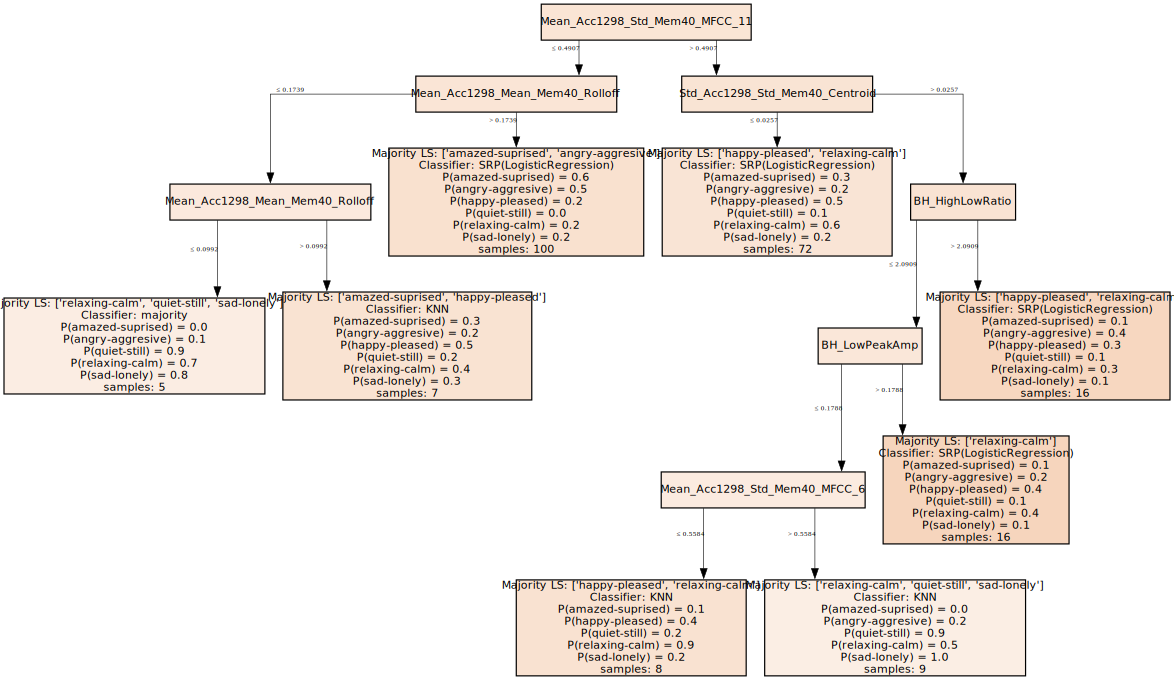

In [4]:
mlhat.draw()

In [10]:
mlhat.to_dataframe()

,parent,is_leaf,depth,stats,feature,threshold,drift_detector,_is_background,_alternate_tree,_mean_error,current_obs,splitter,splitters,_disabled_attrs,_last_split_attempt_at,_rng,mls,low_card_clf,high_card_low_entr_clf
node,,,,,,,,,,,,,,,,,,,
0,<NA>,False,0,"{'amazed-suprised': 144, 'angry-aggresive': 13...",Mean_Acc1298_Std_Mem40_MFCC_11,0.490707,ADWIN,True,NaN,Mean: 0.387172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,False,1,"{'amazed-suprised': 102, 'angry-aggresive': 93...",Mean_Acc1298_Mean_Mem40_Rolloff,0.173941,ADWIN,True,NaN,Mean: 0.388889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,False,1,"{'total': 225.00376423820583, 'quiet-still': 5...",Std_Acc1298_Std_Mem40_Centroid,0.025680,ADWIN,True,NaN,Mean: 0.389277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,False,2,"{'amazed-suprised': 24.291654865177883, 'total...",Mean_Acc1298_Mean_Mem40_Rolloff,0.099208,ADWIN,True,NaN,Mean: 0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,True,2,"{'amazed-suprised': 70.70834513482211, 'total'...",NaN,NaN,ADWIN,True,NaN,Mean: 0.388889,100.0,GaussianSplitter,{'Mean_Acc1298_Mean_Mem40_Centroid': GaussianS...,{},98.0,<random.Random object at 0x7fb288c72210>,MajorityLabelset,"[amazed-suprised, happy-pleased, relaxing-calm...","[amazed-suprised, happy-pleased, relaxing-calm..."
5,2,True,2,"{'amazed-suprised': 23.525822436636023, 'total...",NaN,NaN,ADWIN,True,NaN,Mean: 0.389277,72.0,GaussianSplitter,{'Mean_Acc1298_Mean_Mem40_Centroid': GaussianS...,{},72.0,<random.Random object at 0x7fb288c72210>,MajorityLabelset,"[amazed-suprised, happy-pleased, relaxing-calm...","[amazed-suprised, happy-pleased, relaxing-calm..."
6,2,False,2,"{'amazed-suprised': 20.474177563363977, 'total...",BH_HighLowRatio,2.090909,ADWIN,True,NaN,Mean: 0.379747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3,True,3,"{'relaxing-calm': 50.819300902335506, 'quiet-s...",NaN,NaN,ADWIN,True,NaN,Mean: 0.333333,5.0,GaussianSplitter,{'Mean_Acc1298_Mean_Mem40_Centroid': GaussianS...,{},5.0,<random.Random object at 0x7fb288c72210>,MajorityLabelset,"[amazed-suprised, happy-pleased, relaxing-calm...","[amazed-suprised, happy-pleased, relaxing-calm..."
8,3,True,3,"{'relaxing-calm': 24.180699097664494, 'quiet-s...",NaN,NaN,ADWIN,True,NaN,Mean: 0.333333,7.0,GaussianSplitter,{'Mean_Acc1298_Mean_Mem40_Centroid': GaussianS...,{},5.0,<random.Random object at 0x7fb288c72210>,MajorityLabelset,"[amazed-suprised, happy-pleased, relaxing-calm...","[amazed-suprised, happy-pleased, relaxing-calm..."
